## Wrong lengths

This script processes the csv file including all the lengths and detects(fixes?) thw wrongly created lengths in cases such as:

- 1 real length recorded as 2 lengths (it should be merged)
- 2 real lengths recorded as 1 length (it should be splited)
- Merge consecutive RESTs

How to approach it?
- Compute global stats (mean, mode, ...) of time and strokes and compare each length to detect wrong ones?
- Anomaly detection techniques?

In [92]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# read the csv file with lengths data
lengths_original = pd.read_csv('lengths.csv')

### Identify unusual sets

In [ ]:
# read the csv file with sets data
sets_original = pd.read_csv('sets.csv')

In [62]:
# identify sets with unusual distances (125m, 75m...)
sets_original['unusual_set_distance'] = sets_original.apply(
    lambda x: (str(x['distance'])[-2:] in ('25', '75')) and (x['distance'] != 25),
    axis=1
)
unusual_sets = sets_original[sets_original['unusual_set_distance'] == True]
print(len(unusual_sets))
#unusual_sets[['datetime', 'interval', 'style', 'distance']]

58


### Gaussian Anomaly Detection

In [94]:
# drop rest&drill rows (to avoid disturbing the time and strokes stats)
lengths = lengths_original.drop(lengths_original[\
                                                 (lengths_original['style'] == 'REST') |\
                                                 (lengths_original['style'] == 'DRILL')
                                                ].index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122ee65f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1242ffb38>]], dtype=object)

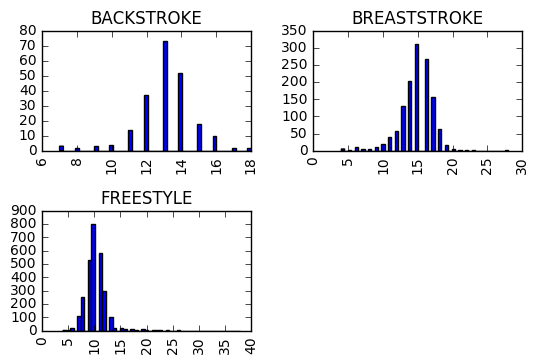

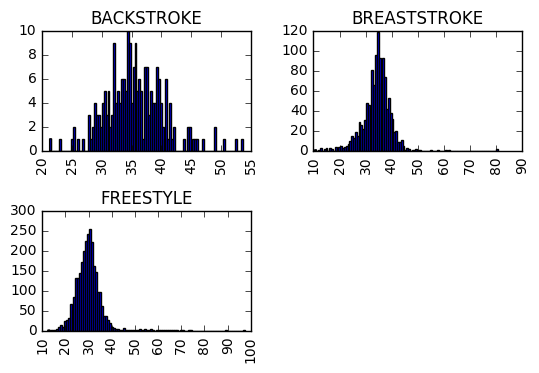

In [95]:
# visually check gaussianity of 'time' and 'strokes'
lengths.hist(column='strokes', by='style', bins=50)
lengths.hist(column='time', by='style', bins=100)

In [96]:
# select only a single style and length distance
lengths_style = lengths[(lengths['style'] == 'FREESTYLE') & (lengths['distance'] == 25)]

In [97]:
# normalize time and strokes features
time_mu = np.mean(lengths_style['time'])
time_sigma = np.std(lengths_style['time'])
lengths_style['time_n'] = lengths_style.apply(
    lambda x: (x['time'] - time_mu)/time_sigma, axis=1
)
strokes_mu = np.mean(lengths_style['strokes'])
strokes_sigma = np.std(lengths_style['strokes'])
lengths_style['strokes_n'] = lengths_style.apply(
    lambda x: (x['strokes'] - strokes_mu)/strokes_sigma, axis=1
)

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [98]:
# function to compute p(x) of N(m,s)
def normpdf(x, mean, sd):
    var = float(sd)**2
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [123]:
# compute p(x)
lengths_style['time_p(x)'] = lengths_style.apply(
    lambda x: normpdf(x['time'], time_mu, time_sigma),
    axis=1
)
lengths_style['strokes_p(x)'] = lengths_style.apply(
    lambda x: normpdf(x['strokes'], strokes_mu, strokes_sigma),
    axis=1
)
lengths_style['p(x)'] = lengths_style['time_p(x)'] * lengths_style['strokes_p(x)']

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [116]:
# see basic stats for wrong_manual = True / False
lengths_style[lengths_style['wrong_manual'] == True].describe()

,interval,length,distance,time,strokes,time_n,strokes_n,time_p(x),strokes_p(x),p(x)
count,20.00000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,2.000000e+01
mean,4.80000,5.900000,25.0,47.071650,17.250000,2.926330,3.055042,3.607159e-03,1.252693e-02,1.951492e-04
std,2.23842,5.035662,0.0,23.309798,8.836974,4.091963,3.983174,7.809259e-03,2.549737e-02,4.579909e-04
min,2.00000,1.000000,25.0,12.437000,5.000000,-3.153677,-2.466518,5.222736e-32,6.664672e-35,3.480782e-66
25%,3.75000,2.000000,25.0,21.187500,7.750000,-1.617553,-1.226984,5.170962e-08,2.141982e-08,1.262040e-14
50%,4.00000,4.000000,25.0,53.781000,19.000000,4.104136,3.843836,1.623879e-05,1.112932e-04,1.941327e-09
75%,6.00000,8.000000,25.0,61.234250,23.000000,5.412531,5.646795,1.393673e-03,8.585675e-03,1.423379e-05
max,12.00000,17.000000,25.0,97.500000,38.000000,11.778872,12.407889,2.752494e-02,9.665227e-02,1.397966e-03


(1e-05, 0.1)

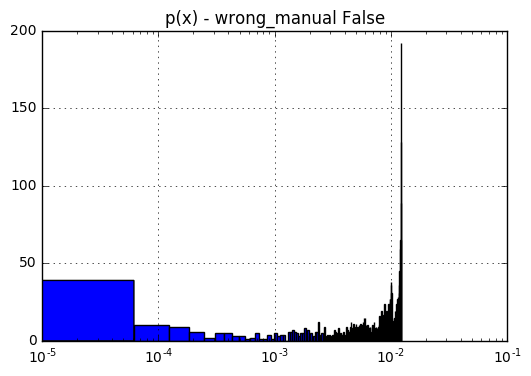

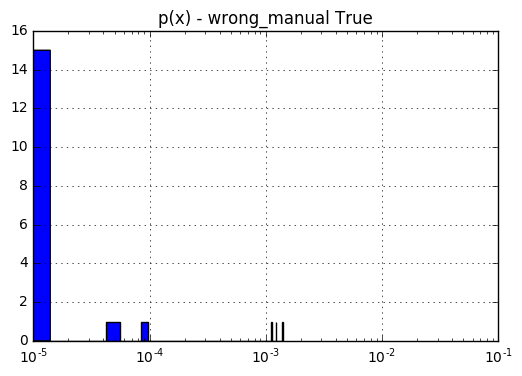

In [140]:
# plot a histogram of p(x) for wrong_manual = True / False
fig, axes = plt.subplots()
lengths_style[lengths_style['wrong_manual'] == False].hist(ax=axes, column='p(x)', bins=200)
axes.set_xscale('log')
axes.set_title('p(x) - wrong_manual False')
axes.set_xlim(0.00001,0.1)

fig, axes = plt.subplots()
lengths_style[lengths_style['wrong_manual'] == True].hist(ax=axes, column='p(x)', bins=100)
axes.set_xscale('log')
axes.set_title('p(x) - wrong_manual True')
axes.set_xlim(0.00001,0.1)

In [141]:
lengths_style[lengths_style['p(x)'] <= 0.0001]

,datetime,interval,length,style,distance,time,strokes,wrong_manual,time_n,strokes_n,time_p(x),strokes_p(x),p(x)
37,2016-07-14 11:56:00,3.0,6.0,FREESTYLE,25.0,46.562,17,False,2.836862,2.942357,1.252415e-03,2.370779e-03,2.969200e-06
350,2016-09-19 18:37:00,5.0,16.0,FREESTYLE,25.0,16.812,6,True,-2.385659,-2.015779,4.068538e-03,2.357695e-02,9.592372e-05
351,2016-09-19 18:37:00,5.0,17.0,FREESTYLE,25.0,69.500,26,True,6.863558,6.999014,4.128936e-12,4.145907e-12,1.711818e-23
392,2016-09-22 18:00:00,1.0,4.0,FREESTYLE,25.0,59.620,26,False,5.129154,6.999014,1.356892e-07,4.145907e-12,5.625547e-19
413,2016-09-22 18:00:00,4.0,3.0,FREESTYLE,25.0,63.812,23,True,5.865047,5.646795,2.375220e-09,2.141982e-08,5.087678e-17
792,2016-10-05 18:27:00,3.0,3.0,FREESTYLE,25.0,43.500,16,False,2.299338,2.491617,4.980304e-03,8.067733e-03,4.017976e-05
793,2016-10-05 18:27:00,3.0,4.0,FREESTYLE,25.0,55.812,20,False,4.460672,4.294576,3.346543e-06,1.777896e-05,5.949804e-11
804,2016-10-05 18:27:00,3.0,15.0,FREESTYLE,25.0,70.620,25,False,7.060171,6.548274,1.050462e-12,8.781841e-11,9.224987e-23
805,2016-10-05 18:27:00,3.0,16.0,FREESTYLE,25.0,57.500,21,False,4.756995,4.745316,8.540407e-07,2.317982e-06,1.979651e-12
814,2016-10-05 18:27:00,3.0,25.0,FREESTYLE,25.0,57.750,21,False,4.800882,4.745316,6.924575e-07,2.317982e-06,1.605104e-12
